In [1]:
import numpy as np
import pylab as plt
%matplotlib inline
import tqdm, json

In [2]:
from frbpa.search import pr3_search, riptide_search, p4j_search
from frbpa.utils import get_phase

In [3]:
with open('r3all_data.json', 'r') as f:
    r3_data = json.load(f)

In [4]:
burst_dict = r3_data['bursts']
startmjds_dict = r3_data['obs_startmjds']
duration_dict = r3_data['obs_duration']

In [5]:
r3_data.keys()

dict_keys(['bursts', 'obs_duration', 'obs_startmjds'])

In [6]:
startmjds_dict.keys()

dict_keys(['CHIME', 'DSN_L', 'DSN_S', 'DSN_X', 'Effelsberg', 'GBT300', 'GMRT', 'LOFAR', 'NC', 'SRT_L', 'SRT_P', 'VLA'])

# Let's do periodicity searches using all bursts of R3 detected till 24th April

In [7]:
bursts = []
for k in burst_dict.keys():
    bursts += burst_dict[k]
bursts = np.array(bursts)

In [8]:
# bursts = np.sort(bursts - np.min(bursts))
unique_days = np.unique(np.round(bursts))

In [9]:
startmjds = []
for k in startmjds_dict.keys():
    startmjds += startmjds_dict[k]
startmjds = np.array(startmjds)

In [10]:
durations = []
for k in duration_dict.keys():
    durations += duration_dict[k]
durations = np.array(durations)

## Pearson chi-square test ([PR3](https://ui.adsabs.harvard.edu/abs/2020arXiv200110275T/abstract))

### Actually, this method would be less sensitive due to non uniform phase coverage, which is the case here. Look at the Fig 1. (phase plot) in the research note. But, let's still try it...

In [11]:
rch, p = pr3_search(bursts=bursts, obs_mjds=startmjds, 
                    obs_durations=durations)

100%|██████████| 370652/370652 [02:54<00:00, 2129.49it/s]
2020-06-19 13:03:56,191 - pr3_search -root - INFO - Max reduced chi square value is 26.32676901606565 at period of 2.1245624050656815


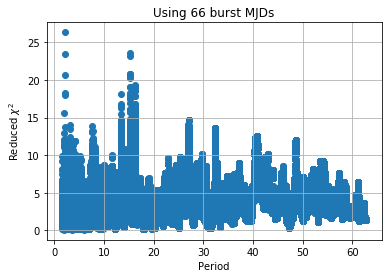

In [12]:
plt.scatter(p, rch)
plt.ylabel(r'Reduced $\chi^2$')
plt.title(f'Using {len(bursts)} burst MJDs')
plt.xlabel('Period')
plt.grid()

### Looks like there are many peaks there. The strongest peak is at 2.12 days, which is probably due to daily CHIME coverage. There is a peak around 16 days as well, and then a few more at its harmonics (32, 48 days). Lot of noise! Let's zoom in a bit

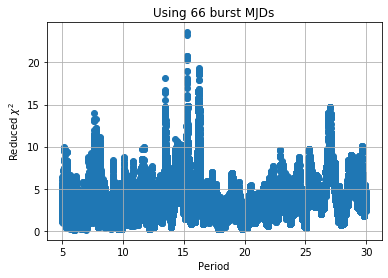

In [13]:
mask = (p > 5) & (p < 30)
plt.scatter(p[mask], rch[mask])
plt.ylabel(r'Reduced $\chi^2$')
plt.title(f'Using {len(bursts)} burst MJDs')
plt.xlabel('Period')
plt.grid()

In [14]:
p[mask][np.argmax(rch[mask])]

15.244580508348823

#### Seems like this peak is actually at 15.24 days. There is one next to it as well, which is probably near 16 days. 

#### Let's try just with the activity days

In [15]:
rch_uniq, p = pr3_search(bursts=unique_days, obs_mjds=startmjds, 
                    obs_durations=durations)

100%|██████████| 371053/371053 [03:02<00:00, 2031.58it/s]
2020-06-19 13:07:03,697 - pr3_search -root - INFO - Max reduced chi square value is 57.44335719452406 at period of 2.990138902364089


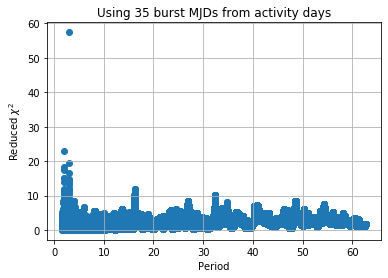

In [16]:
plt.scatter(p, rch_uniq)
plt.ylabel(r'Reduced $\chi^2$')
plt.title(f'Using {len(unique_days)} burst MJDs from activity days')
plt.xlabel('Period')
plt.grid()

### The peak at 16 day period got weaker, and the one at the alias of sidereal day got very strong. Let's zoom in around 16 day

In [17]:
mask = (p > 10) & (p < 40)

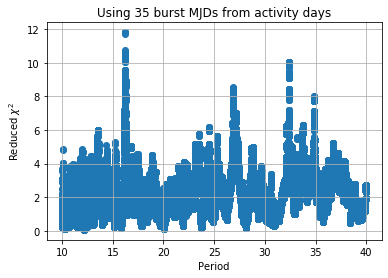

In [18]:
plt.scatter(p[mask], rch_uniq[mask])
plt.ylabel(r'Reduced $\chi^2$')
plt.title(f'Using {len(unique_days)} burst MJDs from activity days')
plt.xlabel('Period')
plt.grid()

In [19]:
p[mask][np.argmax(rch_uniq[mask])]

16.182777157918565

#### So there is a peak around 16 day, although there is a lot of noise as well.  

# Searching for period with narrowest folded profile (Rajwade et al 2020)
### Rajwade et al (2020) actually call it searching for the largest continuous fraction in the folded profile without burst signal

In [20]:
bursts = np.sort(bursts - np.min(bursts))
unique_days = np.unique(np.round(bursts))

In [21]:
cont_frac, p = riptide_search(bursts, pmin=1, pmax=50)

2020-06-19 13:07:08,594 - riptide_search -root - WARNING - Period/nbins should be greater than tsamp. Not all periods in the given range are valid. Selecting the valid periods from 2.00036619976197 days for search.
100%|██████████| 3425/3425 [00:03<00:00, 1009.22it/s]
2020-06-19 13:07:11,990 - riptide_search -root - INFO - Max continuous fraction without data is 0.7 at a period of 16.300648109292673 days


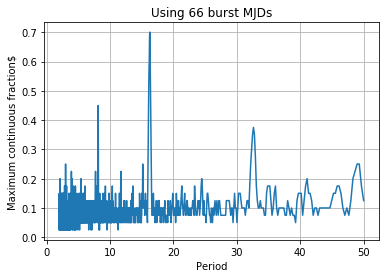

In [22]:
plt.plot(p, cont_frac)
plt.ylabel(r'Maximum continuous fraction$')
plt.title(f'Using {len(bursts)} burst MJDs')
plt.xlabel('Period')
plt.grid()

#### This was quick. :) <br>  As has been noted in the log and can be seen in the plot, strongest peak occurs at 16.30 day period, which is consistent with PR3. <br> Let's just use the unique days now


In [23]:
cont_frac_uniq, p = riptide_search(unique_days, pmin=1, pmax=50)

2020-06-19 13:07:12,151 - riptide_search -root - WARNING - Period/nbins should be greater than tsamp. Not all periods in the given range are valid. Selecting the valid periods from 2.0003431120260764 days for search.
100%|██████████| 3427/3427 [00:03<00:00, 1011.11it/s]
2020-06-19 13:07:15,543 - riptide_search -root - INFO - Max continuous fraction without data is 0.725 at a period of 16.269767441860466 days


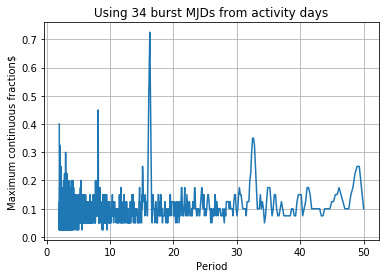

In [24]:
plt.plot(p, cont_frac_uniq)
plt.ylabel(r'Maximum continuous fraction$')
plt.title(f'Using {len(unique_days)} burst MJDs from activity days')
plt.xlabel('Period')
plt.grid()

#### Again we get a peak at 16.26 day, consistent with PR3. All good. 

# Using P4J
### using QMI based on Euclidean distance for periodogram. See https://github.com/phuijse/P4J

In [25]:
bursts = []
for k in burst_dict.keys():
    bursts += burst_dict[k]
bursts = np.array(bursts)
unique_days = np.unique(np.round(bursts))
# unique_days = unique_days - np.min(unique_days)

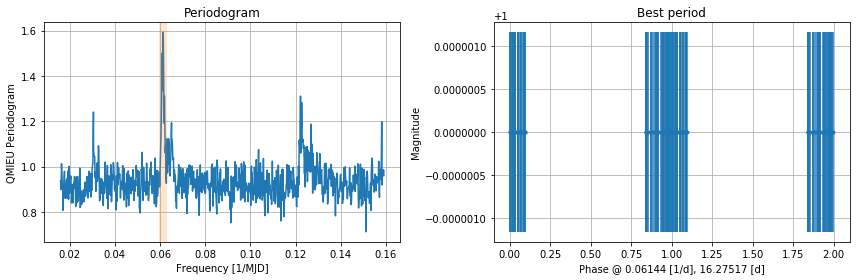

In [26]:
periodogram, p = p4j_search(bursts, pmin=2*np.pi, pmax=np.pi*20, plot=True, save=False, mjd_err=0.1)

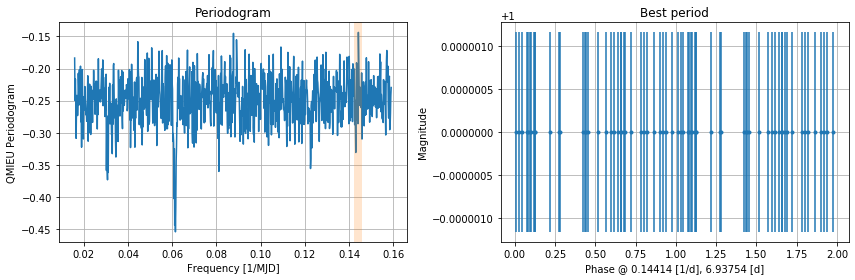

In [27]:
periodogram_unique, p = p4j_search(unique_days, pmin=2*22/7, pmax=20*22/7, plot=True, save=False, mjd_err=0.1)

#### There clearly is a peak just above freq=0.06, which corresponds to a period of ~16.4 days, consistent with PR3. Have to look into why the periodogram looks inverted. 

#### but P4J also recovers the period reported by PR3

#### By using all the available bursts from R3, we are able to recover the period reported by PR3. This again improves the confidence in this period. 